In [207]:
# База
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import functools

import re

# Сохранение объектов питона
import pickle

# Визуализация
import matplotlib.pyplot as plt

# Работа с текстом
# Молельки, метрики и утилитки
import nltk
from nltk.corpus import stopwords
import gensim.downloader as api
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Prep

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
nltk.download("stopwords")
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sephansavchenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sephansavchenko/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sephansavchenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
balichat_df = pd.read_csv('./balichat.csv')
balichatik_df = pd.read_csv('./balichatik.csv')

In [10]:
df = pd.concat([balichatik_df, balichat_df], ignore_index=True, sort=False)
df['text'] = df['text'].astype(str)
raw_df = df.copy()

In [12]:
q_words = [
    'как',
    'что',
    'сколько',
    'где',
    'какой',
    'кто',
    'когда',
    'почему',
    'чем',
    'чего',
    'куда',
    'который',
    'кому',
    'зачем',
    'откуда',
    'чей',
    'чья',
    'каков',
    'отчего',
    'сколько',
    'каком',
    'котором',
    'кто',
    'что',
    'кого',
    'чего',
    'кому',
    'чему',
    'кого',
    'что',
    'чем',
]

# EDA v1

In [9]:
df.shape

(20002, 3)

In [11]:
df.keys()

Index(['text', 'reply_to_message_id', 'mentioned'], dtype='object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20002 entries, 0 to 20001
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   text                 20002 non-null  object 
 1   reply_to_message_id  13218 non-null  float64
 2   mentioned            19987 non-null  object 
dtypes: float64(1), object(2)
memory usage: 468.9+ KB


In [15]:
df.head()

text  reply_to_message_id  \
0  Привет! \nТоже лечу одна в январе, можем искат...            1453271.0   
1  Продам 2 билета на Гуфа 4 января пишите в личк...                  NaN   
2  Мы два дня назад 6 часов прекрасно провели в Ш...            1453295.0   
3  Всем привет,мне 15 лет ❤️\nПродаю свои горячие...                  NaN   
4                 Где то говорили , что не выпускают            1453294.0   

  mentioned  
0     False  
1     False  
2     False  
3     False  
4     False

In [17]:
df['mentioned'].value_counts()

mentioned
False    19987
Name: count, dtype: int64

In [19]:
df[df['mentioned'] == True]

Empty DataFrame
Columns: [text, reply_to_message_id, mentioned]
Index: []

In [21]:
df['text_len'] = df['text'].apply(lambda x: len(x))
df['text_len'].head()

0     72
1     50
2     51
3    141
4     34
Name: text_len, dtype: int64

In [23]:
df['text_len'].describe()

count    20002.000000
mean        78.410759
std        123.536979
min          1.000000
25%         19.000000
50%         47.000000
75%         90.000000
max       2693.000000
Name: text_len, dtype: float64

In [25]:
out = pd.cut(df['text_len'], bins=[0, 10, 50, 100 ,500, 1000, 5000], include_lowest=True)
df['text_len_bin'] = out

<Axes: xlabel='text_len_bin'>

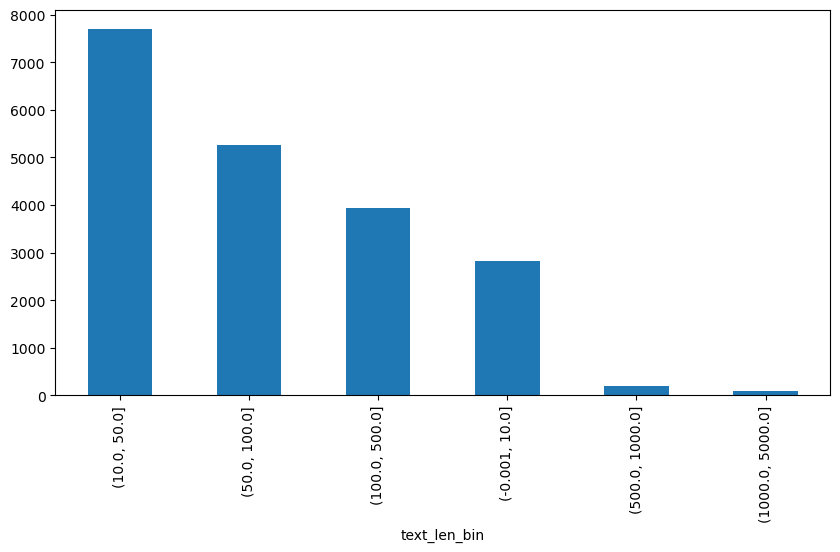

In [27]:
df['text_len_bin'].value_counts().plot(kind='bar', figsize=(10,5))

In [29]:
out.value_counts(sort=True)

text_len
(10.0, 50.0]        7704
(50.0, 100.0]       5260
(100.0, 500.0]      3938
(-0.001, 10.0]      2815
(500.0, 1000.0]      197
(1000.0, 5000.0]      88
Name: count, dtype: int64

# Preproc

In [37]:
df = df.drop_duplicates(subset=['text'], keep=False).copy()
df['text'].loc[df['text'].duplicated()].shape

In [41]:
df.shape

(16579, 5)

In [125]:
stemmer = nltk.stem.snowball.SnowballStemmer("russian")
stopwords = stopwords.words("russian")

In [161]:
q_words_stemmed = set(map(lambda t: stemmer.stem(t), q_words))
q_words_stemmed

{'где',
 'зач',
 'как',
 'ког',
 'когд',
 'ком',
 'котор',
 'кто',
 'куд',
 'откуд',
 'отч',
 'поч',
 'скольк',
 'че',
 'чег',
 'чем',
 'что',
 'чья'}

In [145]:
df['text_tokenized'] = df['text'].apply(lambda txt: nltk.word_tokenize(txt))

In [153]:
def stem_tokens(tokens):
    return list(map(lambda t: stemmer.stem(t), tokens))

df['text_stemmed'] = df['text_tokenized'].apply(stem_tokens)
df['text_stemmed'].head(3)

0    [привет, !, тож, леч, одн, в, январ, ,, мож, и...
1    [прод, 2, билет, на, гуф, 4, январ, пиш, в, ли...
2    [мы, два, дня, назад, 6, час, прекрасн, провел...
Name: text_stemmed, dtype: object

In [157]:
df[df['text'].apply(lambda txt: '?' in txt)].shape

(4997, 7)

In [163]:
def is_question(txt):
    if '?' in txt:
        return True
    for qws in q_words_stemmed:
        if qws in txt:
            return True
    return False

In [165]:
df['is_question'] = df['text'].apply(is_question)
df['is_question'].head(3)

0    False
1    False
2    False
Name: is_question, dtype: bool

In [167]:
df[df['is_question']].shape

(9106, 8)

In [187]:
df[df['is_question']]['text']

4                       Где то говорили , что не выпускают
7        Я перепробовал много где, но мои самые любимые...
9          Где вкусные и недорогие сырники в районе чангу?
12       Noiзe MC уже сегодня! \n\nНа танцпол осталось ...
15       На 50к дороже кальян чем в Ahahac, но атмосфер...
                               ...                        
19996    Приложение трип.ком\nНадо выбрать малазийскую ...
19997    А где покупали? Через какой сервис, по русской...
19999    Я скажу грубо. У вас через 3 месяца перестанет...
20000                                          где купили?
20001    Я купил возвратный билет. Вышел из аэропорта и...
Name: text, Length: 9106, dtype: object

In [197]:
temp = df[df['text'].apply(lambda t: 'Noiзe MC уже сегодня!' in t)].iloc[0]
temp

text                   Noiзe MC уже сегодня! \n\nНа танцпол осталось ...
reply_to_message_id                                            1453203.0
mentioned                                                          False
text_len                                                             416
text_len_bin                                              (100.0, 500.0]
text_tokenized         [Noiзe, MC, уже, сегодня, !, На, танцпол, оста...
text_stemmed           [Nоиз, MC, уж, сегодн, !, на, танцпол, оста, о...
is_question                                                         True
Name: 12, dtype: object

In [277]:
df['text_url_filtered'] = df['text'].apply(
    lambda t: re.sub(r'^https?:\/\/.*[\r\n]*', '', t, flags=re.MULTILINE),
)

In [220]:
df[df['text'].apply(lambda txt: '?' in txt)].shape

(4997, 9)

In [222]:
df[df['text_url_filtered'].apply(lambda txt: '?' in txt)].shape

(4906, 9)

In [54]:
def has_q_word(txt):
    for qws in q_words_stemmed:
        if qws in txt:
            return True
    return False

In [228]:
df['has_q_word'] = df['text'].apply(has_q_word)
df['has_q_mark'] = df['text'].apply(lambda txt: '?' in txt)

In [234]:
df[df['has_q_word']].shape[0], df[df['has_q_mark']].shape[0]

(7500, 4997)

In [238]:
df['is_question'] = df['has_q_word'] & df['has_q_mark']

16583

In [240]:
df[df['is_question']].shape[0]

3391

In [258]:
df[df['is_question']]['text']

17       Ребята, а кто где НГ встречает?)\nИщу компанию...
34       Кто в Сануре хочет сейчас погулять?)\nБуду рад...
38       Скажите, пжл, на Бали кто- нибудь обучает езде...
42       Ребята, привет! У кого-нибудь есть ненужный би...
43       Друзья, добрый день!\n\nПодскажите, пожалуйста...
                               ...                        
19988              Всем привет,может есть у кого пром код?
19990    Я спрошу прямо, вы сталкивались с ситуацией, ч...
19991    Кто нибудь здесь смотрел кораллы и рыбок?\nВ Б...
19997    А где покупали? Через какой сервис, по русской...
20000                                          где купили?
Name: text, Length: 3391, dtype: object

In [262]:
df["text_lower"] = df["text"].str.lower()

In [293]:
df['text_cleaned'] = df['text_lower'].apply(lambda t: re.sub(r'_','', re.sub(r'[^\w\s]','', t)))

In [295]:
df['text_tokenized'] = df['text_cleaned'].apply(lambda txt: nltk.word_tokenize(txt))

In [297]:
stop_words = set(stopwords.words('russian'))

df['text_tokenized_cleaned'] = df['text_tokenized'].apply(lambda t: list([w for w in t if w not in stop_words]))

In [299]:
df['text_tokenized_cleaned']

0        [привет, лечу, одна, январе, можем, искать, вм...
2        [дня, назад, 6, часов, прекрасно, провели, шан...
3        [всем, приветмне, 15, лет, продаю, свои, горяч...
4                                    [говорили, выпускают]
5                                        [вообще, проблем]
                               ...                        
19997                   [покупали, сервис, русской, карте]
19998                      [посоветуйте, педагога, латине]
19999    [скажу, грубо, 3, месяца, перестанет, работать...
20000                                             [купили]
20001    [купил, возвратный, билет, вышел, аэропорта, с...
Name: text_tokenized_cleaned, Length: 16578, dtype: object

In [303]:
df['text_cleaned_final'] = df['text_tokenized_cleaned'].apply(lambda tt: ' '.join(tt))
df['text_cleaned_final']

0        привет лечу одна январе можем искать вместе лс...
2               дня назад 6 часов прекрасно провели шанхае
3        всем приветмне 15 лет продаю свои горячие фото...
4                                       говорили выпускают
5                                           вообще проблем
                               ...                        
19997                        покупали сервис русской карте
19998                          посоветуйте педагога латине
19999    скажу грубо 3 месяца перестанет работать телеф...
20000                                               купили
20001    купил возвратный билет вышел аэропорта сдал ни...
Name: text_cleaned_final, Length: 16578, dtype: object

In [305]:
q_df = df[df['is_question']].copy()
q_df.shape

(3391, 15)

# Prepoc v2

In [14]:
df = raw_df.copy()

In [16]:
df = df.drop_duplicates(subset=['text'], keep=False).copy()
df['text'].loc[df['text'].duplicated()].shape

(0,)

In [18]:
df["text_lower"] = df["text"].str.lower()

In [20]:
df['text_url_filtered'] = df['text_lower'].apply(
    lambda t: re.sub(r'^https?:\/\/.*[\r\n]*', '', t, flags=re.MULTILINE),
)

In [22]:
df['text_cleaned'] = df['text_url_filtered'].apply(lambda t: re.sub(r'_','', re.sub(r'[^\w\s]','', t)))

In [24]:
df['text_tokenized'] = df['text_cleaned'].apply(nltk.word_tokenize)

In [26]:
stop_words = set(stopwords.words('russian'))

def remove_stopwords(tokens):
    return list([t for t in tokens if t not in stop_words])

df['text_tokenized_cleaned'] = df['text_tokenized'].apply(remove_stopwords)

In [46]:
m = Mystem()

def lemmatize(tokens):
    return list([m.lemmatize(t)[0] for t in tokens])

In [48]:
q_words_lemmatized = set(lemmatize(q_words))
q_words_lemmatized

{'где',
 'зачем',
 'как',
 'каков',
 'какой',
 'когда',
 'который',
 'кто',
 'куда',
 'откуда',
 'отчего',
 'почему',
 'сколько',
 'чей',
 'что'}

In [50]:
df['text_lemmatized_cleaned'] = df['text_tokenized_cleaned'].apply(lemmatize)
df['text_lemmatized_cleaned']

0        [привет, лететь, один, январь, мочь, искать, в...
1        [продавать, 2, билет, гуфа, 4, январь, писать,...
2        [день, назад, 6, час, прекрасно, проводить, ша...
3        [все, приветмна, 15, год, продавать, свой, гор...
4                                    [говорить, выпускать]
                               ...                        
19997                   [покупать, сервис, русский, карта]
19998                       [посоветовать, педагог, латин]
19999    [сказать, грубо, 3, месяц, переставать, работа...
20000                                             [купить]
20001    [купить, возвратный, билет, выходить, аэропорт...
Name: text_lemmatized_cleaned, Length: 16579, dtype: object

In [52]:
df['text_cleaned_final'] = df['text_lemmatized_cleaned'].apply(lambda tt: ' '.join(tt))
df['text_cleaned_final']

0        привет лететь один январь мочь искать вместе л...
1             продавать 2 билет гуфа 4 январь писать личка
2              день назад 6 час прекрасно проводить шанхай
3        все приветмна 15 год продавать свой горячий фо...
4                                       говорить выпускать
                               ...                        
19997                        покупать сервис русский карта
19998                           посоветовать педагог латин
19999    сказать грубо 3 месяц переставать работать тел...
20000                                               купить
20001    купить возвратный билет выходить аэропорт сдав...
Name: text_cleaned_final, Length: 16579, dtype: object

In [60]:
def has_q_word_v2(txt):
    for qws in q_words_lemmatized:
        if qws in txt:
            return True
    return False

In [62]:
df['has_q_word'] = df['text'].apply(has_q_word_v2)
df['has_q_mark'] = df['text'].apply(lambda txt: '?' in txt)

In [64]:
df['is_question'] = df['has_q_word'] & df['has_q_mark']

In [66]:
df[df['is_question']].shape[0]

2815

In [70]:
df[df['is_question']]['text']

17       Ребята, а кто где НГ встречает?)\nИщу компанию...
38       Скажите, пжл, на Бали кто- нибудь обучает езде...
43       Друзья, добрый день!\n\nПодскажите, пожалуйста...
48       Ребят, привет! А где/ у кого можно взять хорош...
57       Подскажите, где можно в Убуде  по курить калья...
                               ...                        
19976    Ребята, кто сегодня-завтра летит из России на ...
19990    Я спрошу прямо, вы сталкивались с ситуацией, ч...
19991    Кто нибудь здесь смотрел кораллы и рыбок?\nВ Б...
19997    А где покупали? Через какой сервис, по русской...
20000                                          где купили?
Name: text, Length: 2815, dtype: object

In [157]:
df = df[df['is_question']].copy()

# Vectorization

In [159]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['text_cleaned_final'])
vectorizer.get_feature_names_out()
print(X.shape)

(16579, 15841)


In [161]:
num_clusters = 7

# Clusterization

In [163]:
# Метод к-средних - KMeans

km = KMeans(n_clusters=num_clusters)
idx = km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

# print(clusters)
print(km.labels_)

[3 5 1 ... 3 3 2]


<Axes: xlabel='km_labels'>

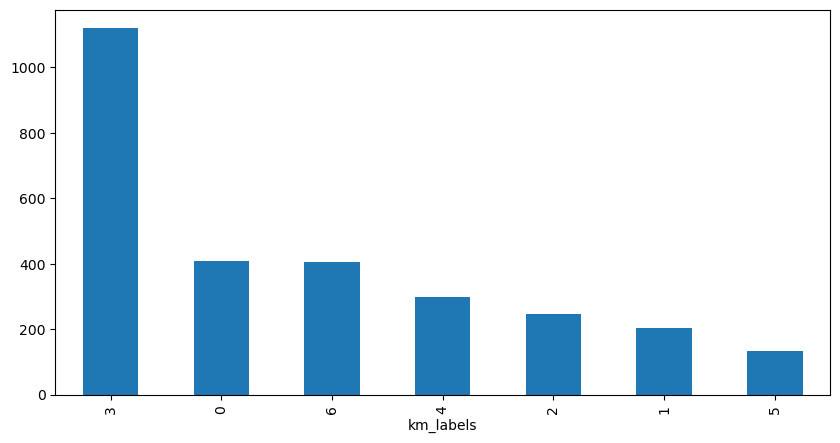

In [180]:
df['km_labels'] = km.labels_
df['km_labels'].value_counts().plot(kind='bar', figsize=(10,5))

In [167]:
# MiniBatchKMeans
mbk  = MiniBatchKMeans(init='random', n_clusters=num_clusters) #(init='k-means++', ‘random’ or an ndarray)
mbk.fit_transform(tfidf_matrix)
mbk.fit(tfidf_matrix)
miniclusters = mbk.labels_.tolist()
print(mbk.labels_)

[2 2 6 ... 2 2 3]


<Axes: xlabel='mbk_labels'>

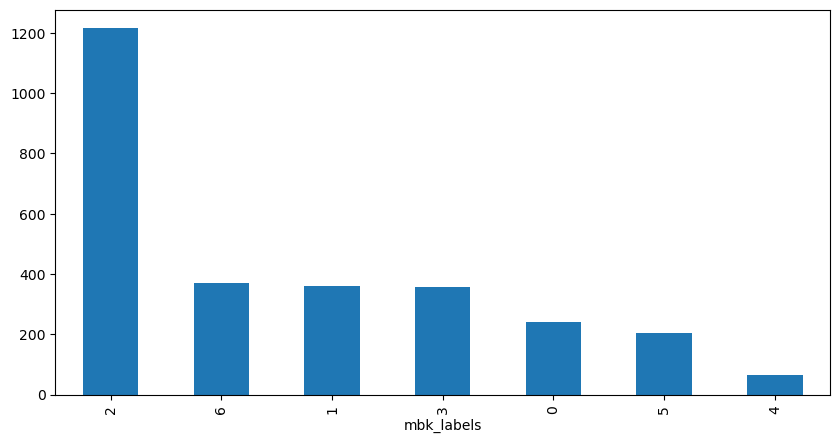

In [182]:
df['mbk_labels'] = mbk.labels_
df['mbk_labels'].value_counts().plot(kind='bar', figsize=(10,5))

In [171]:
# DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(tfidf_matrix)
print( db.labels_)

[-1 -1 -1 ... -1 -1 -1]


<Axes: xlabel='db_labels'>

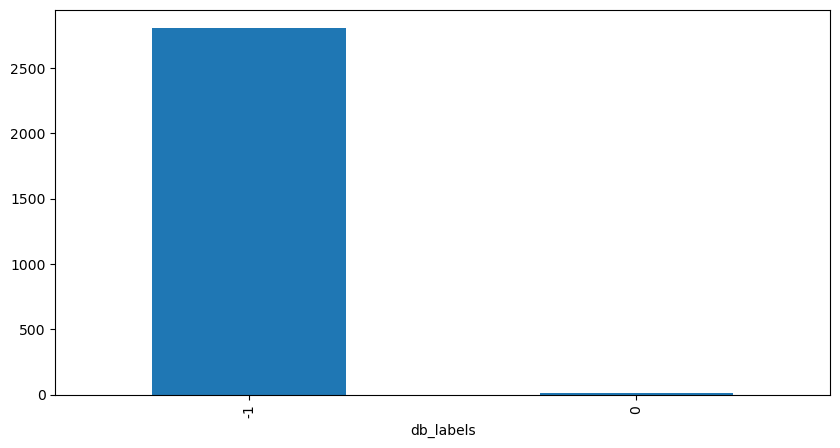

In [184]:
df['db_labels'] = db.labels_
df['db_labels'].value_counts().plot(kind='bar', figsize=(10,5))

In [175]:
# Аггломеративная класстеризация
agg_c = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean').fit(tfidf_matrix.toarray())
print(agg_c.labels_)

[0 0 0 ... 0 0 0]


<Axes: xlabel='agg_c_labels'>

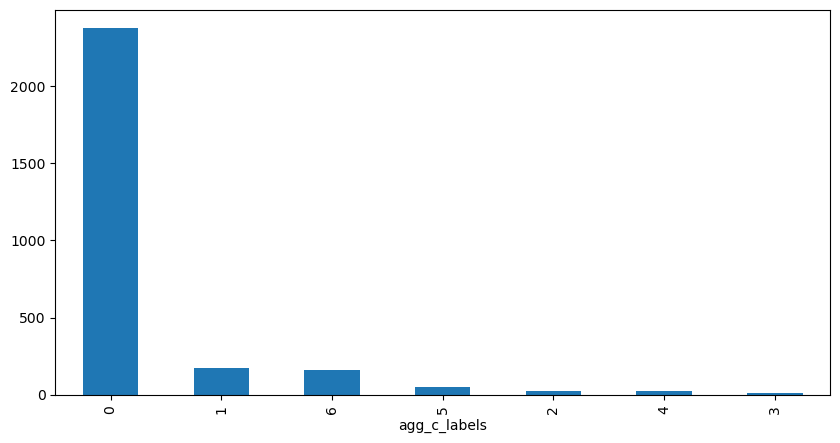

In [186]:
df['agg_c_labels'] = agg_c.labels_
df['agg_c_labels'].value_counts().plot(kind='bar', figsize=(10,5))

# EDA v2

In [263]:
def generate_wordcloud(series, stopwords):
    words = functools.reduce(
        lambda text, subtext : f'{text} {subtext} ', 
        series, 
        '',
    )
    return WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)
    
    
def generate_wordclouds(df, clusters_column, stopwords = None, clusters_len = 7):
    wordclouds = []
    for k in range(clusters_len):
        print(f'generating {k} wordcloud.')
        wordclouds.append(
            generate_wordcloud(
                df[df[clusters_column] == k]['text_cleaned_final'],
                stopwords,
            ),
        )
    return wordclouds
    
def show_wordclouds(wordclouds):
    for wordcloud in wordclouds:
        plt.figure(figsize = (8, 8), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.show()

## KMeans

<Axes: xlabel='km_labels'>

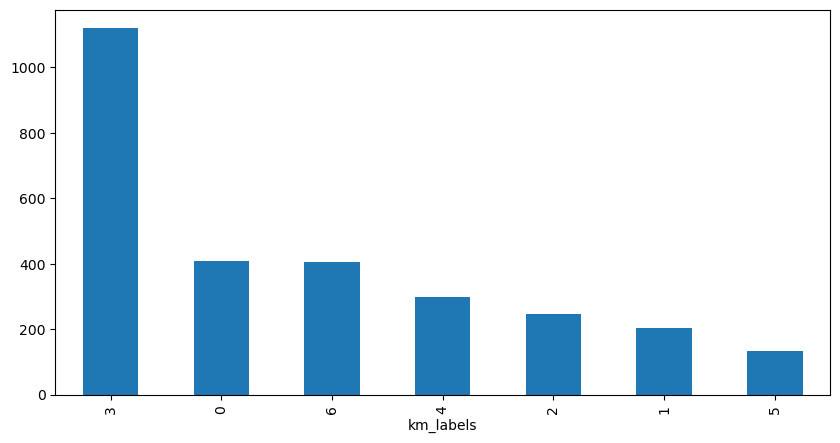

In [265]:
df['km_labels'].value_counts().plot(kind='bar', figsize=(10,5))

In [267]:
km_wordclouds = generate_wordclouds(df, 'km_labels')

generating 0 wordcloud.
generating 1 wordcloud.
generating 2 wordcloud.
generating 3 wordcloud.
generating 4 wordcloud.
generating 5 wordcloud.
generating 6 wordcloud.


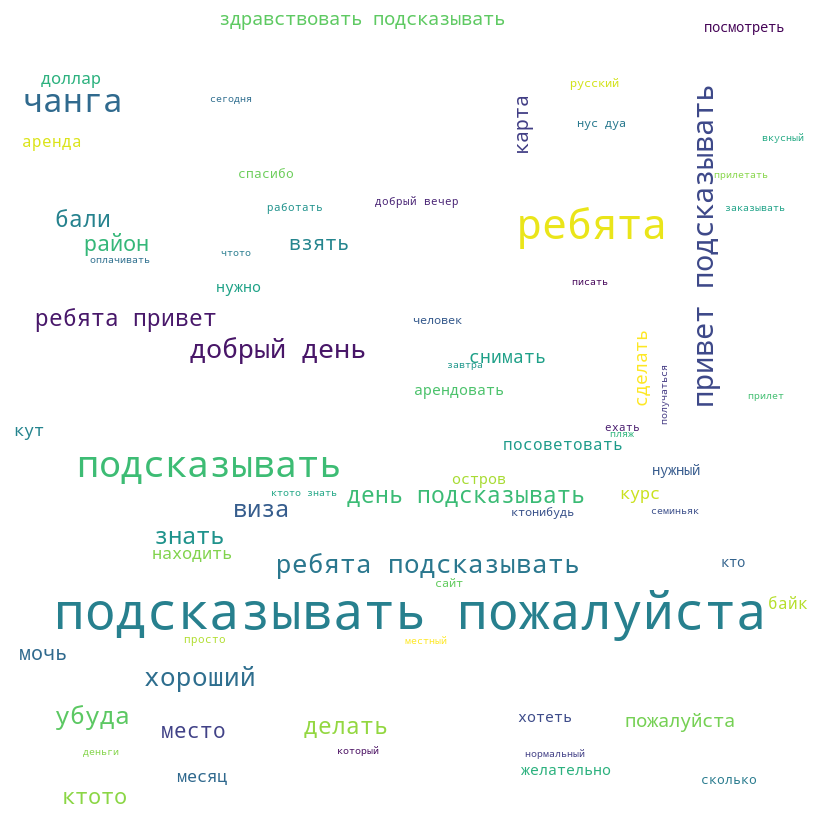

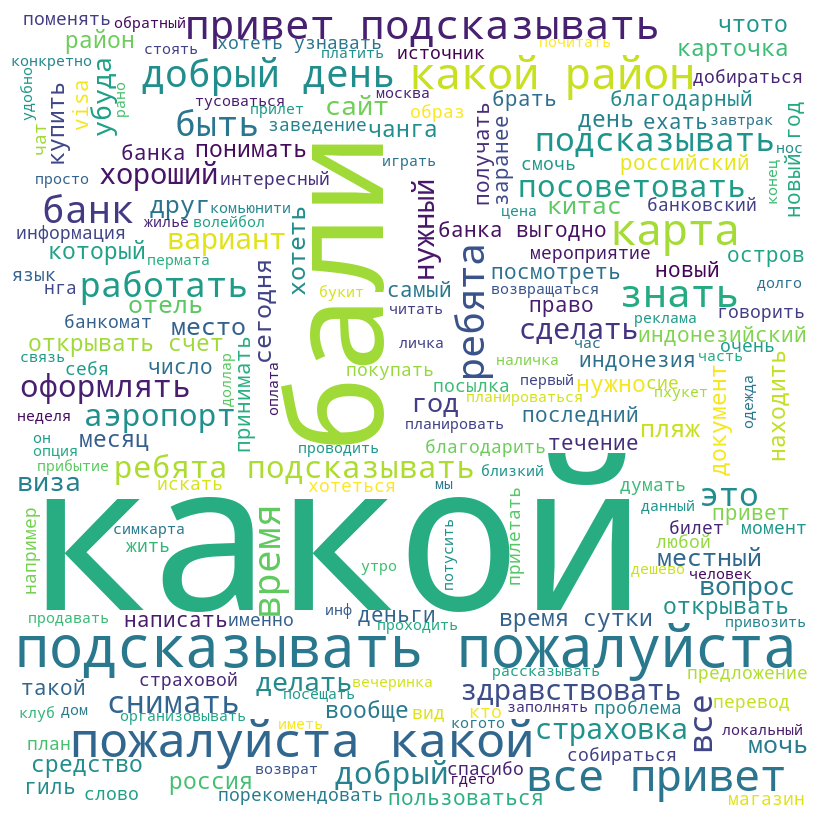

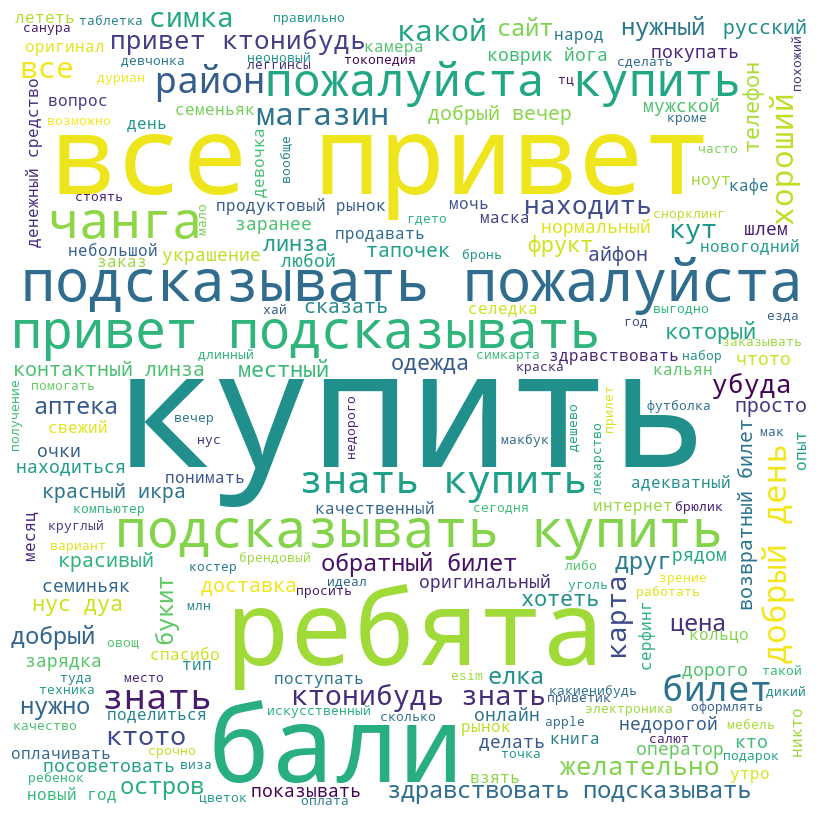

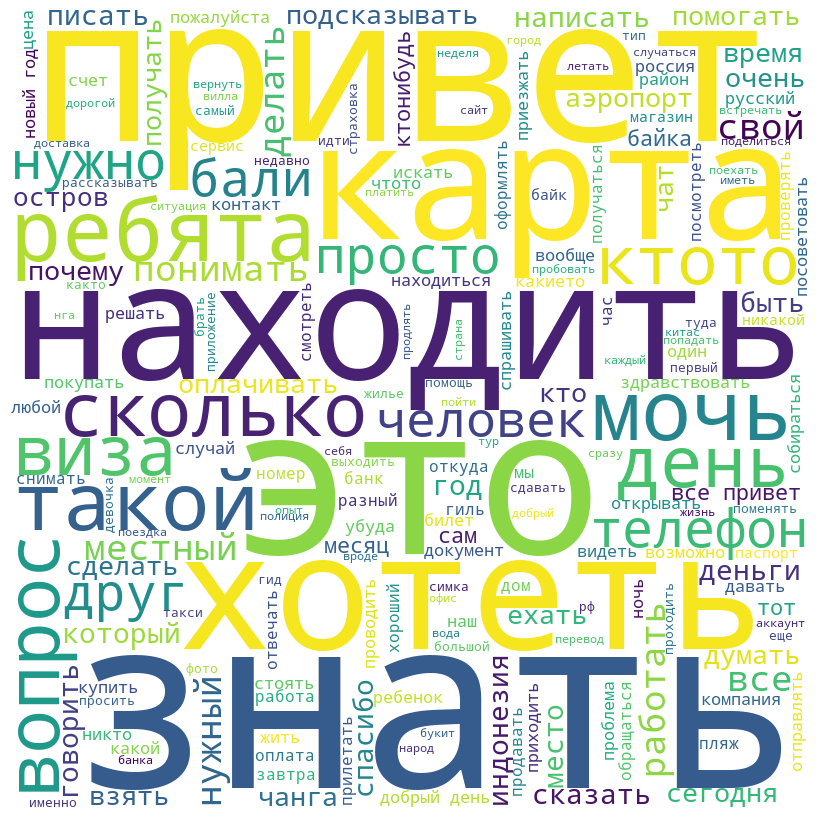

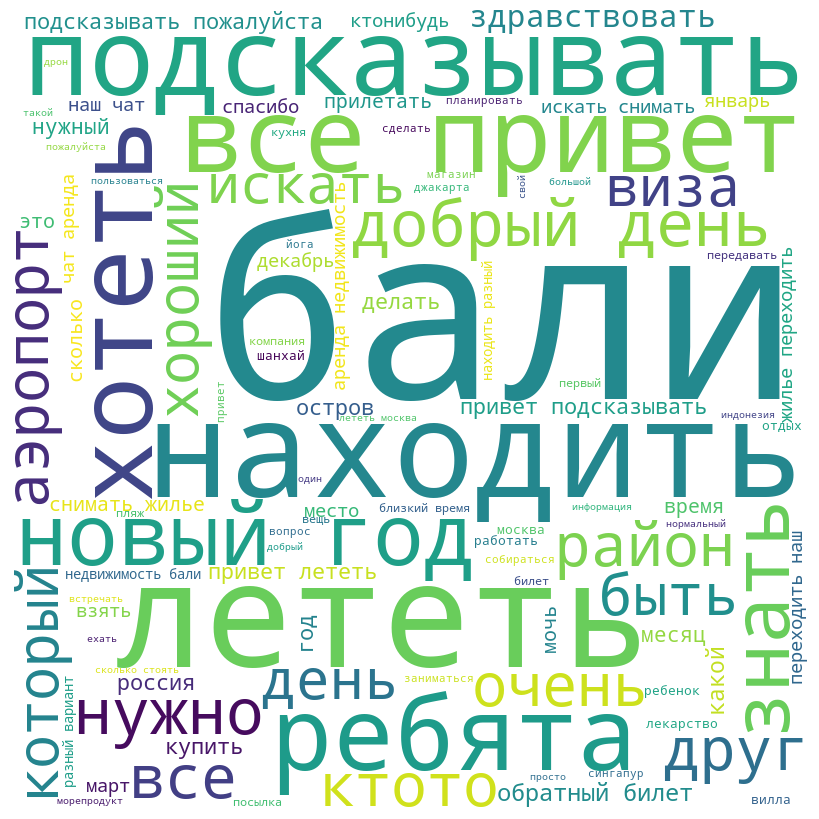

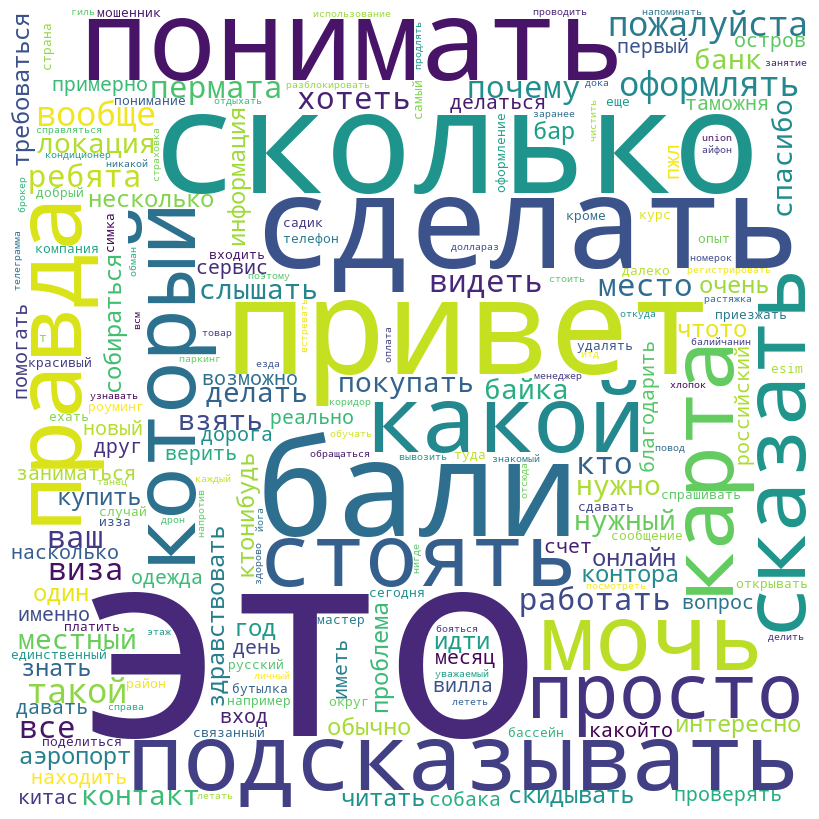

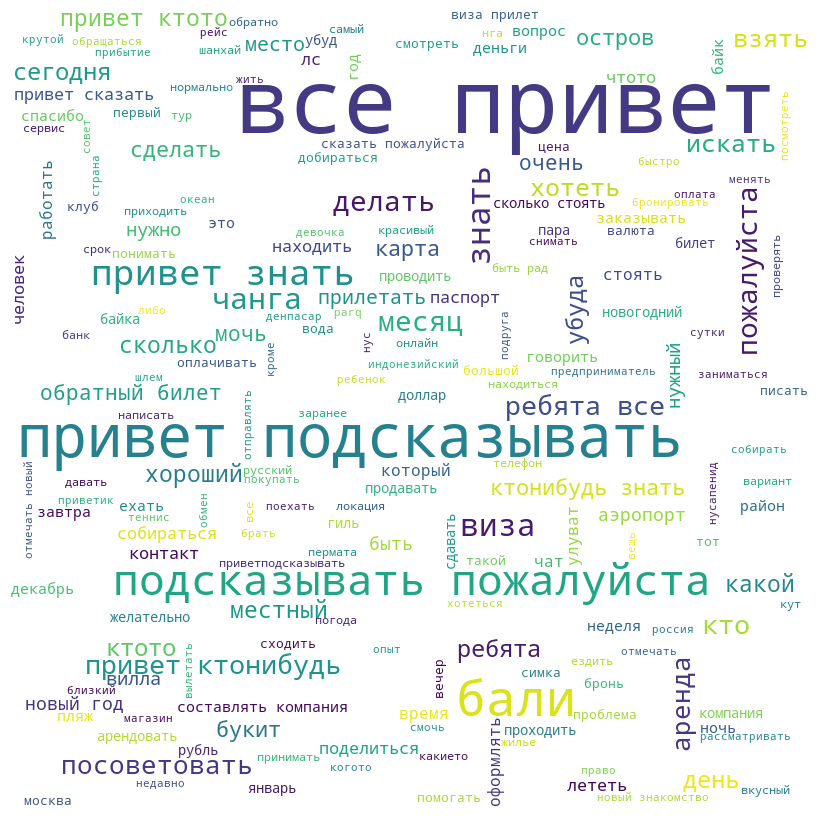

In [261]:
show_wordclouds(km_wordclouds)

## MiniBatchKMeans

generating 0 wordcloud.
generating 1 wordcloud.
generating 2 wordcloud.
generating 3 wordcloud.
generating 4 wordcloud.
generating 5 wordcloud.
generating 6 wordcloud.


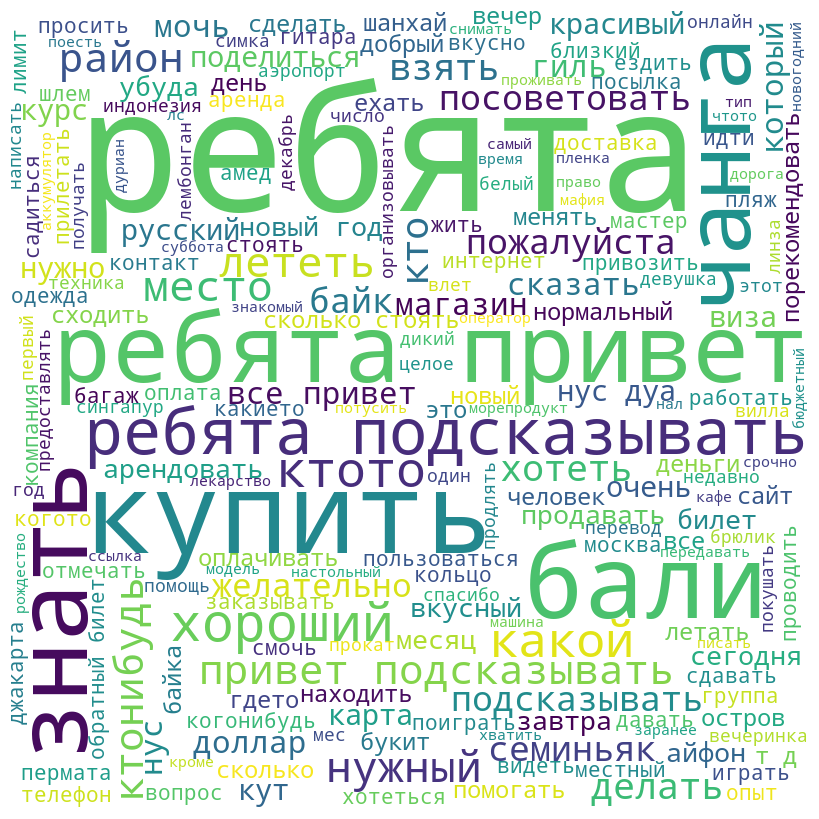

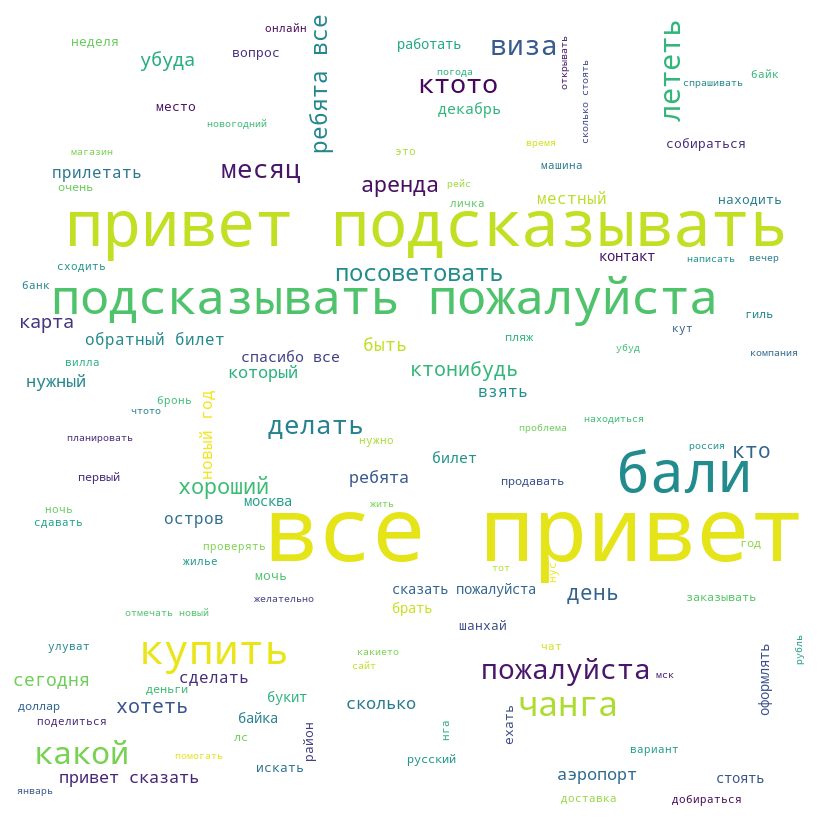

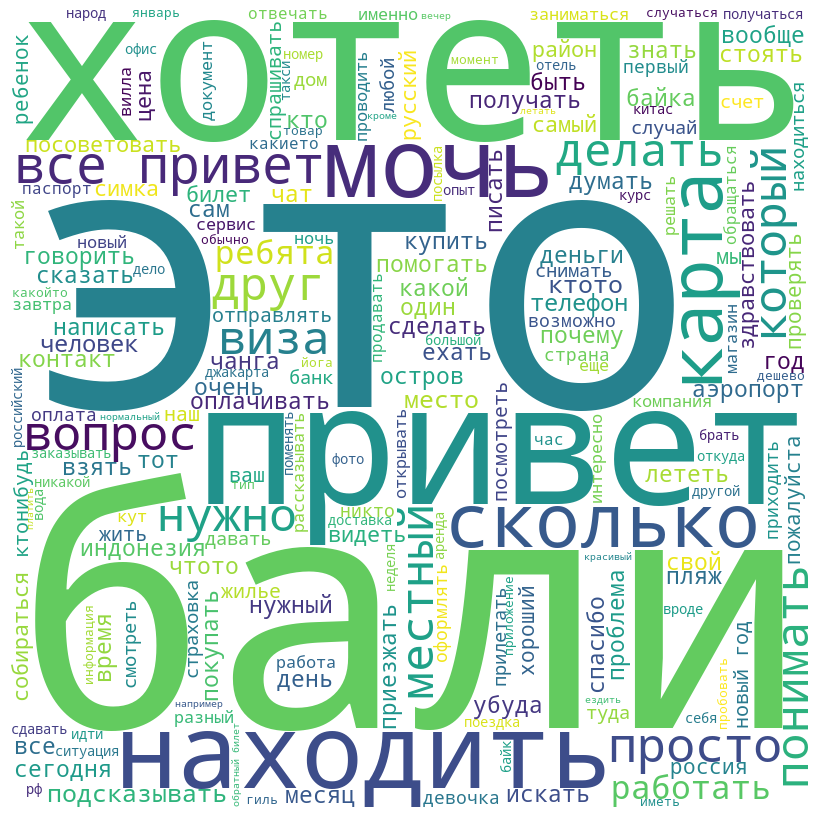

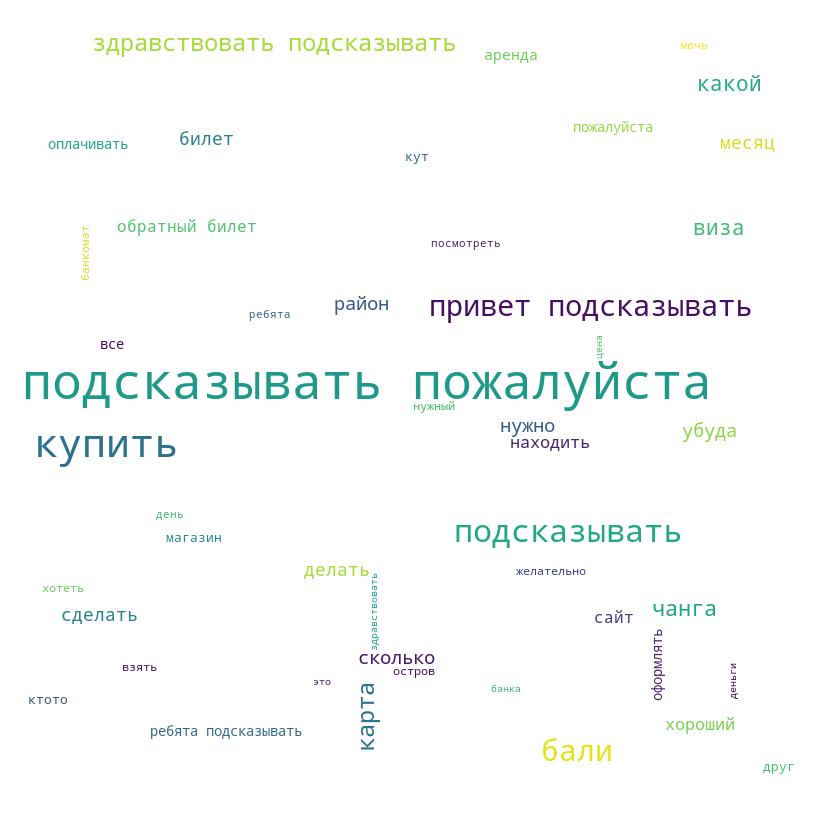

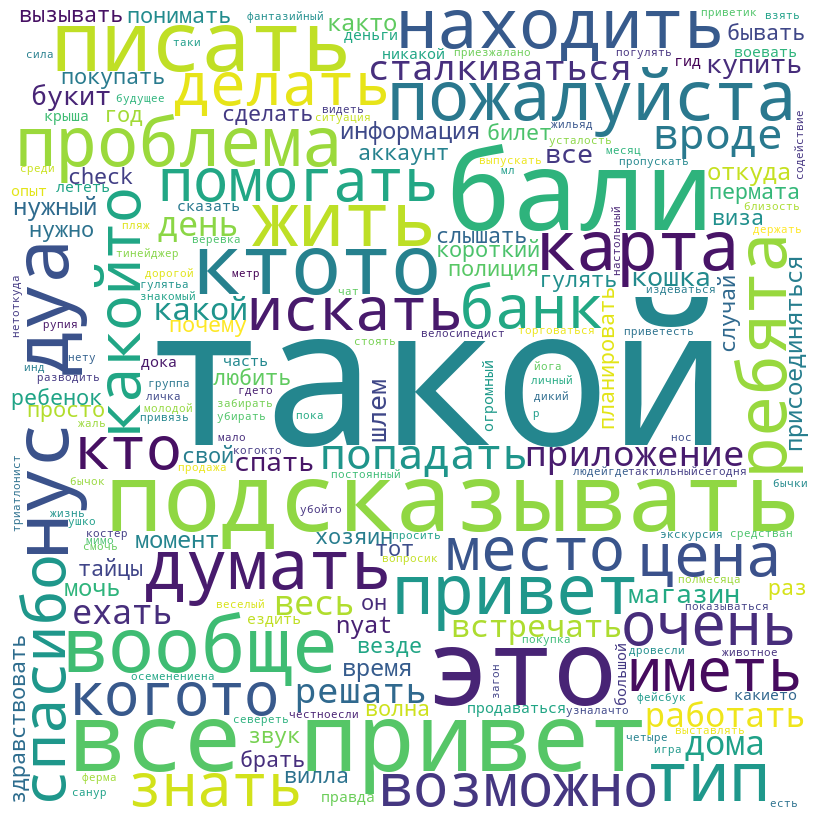

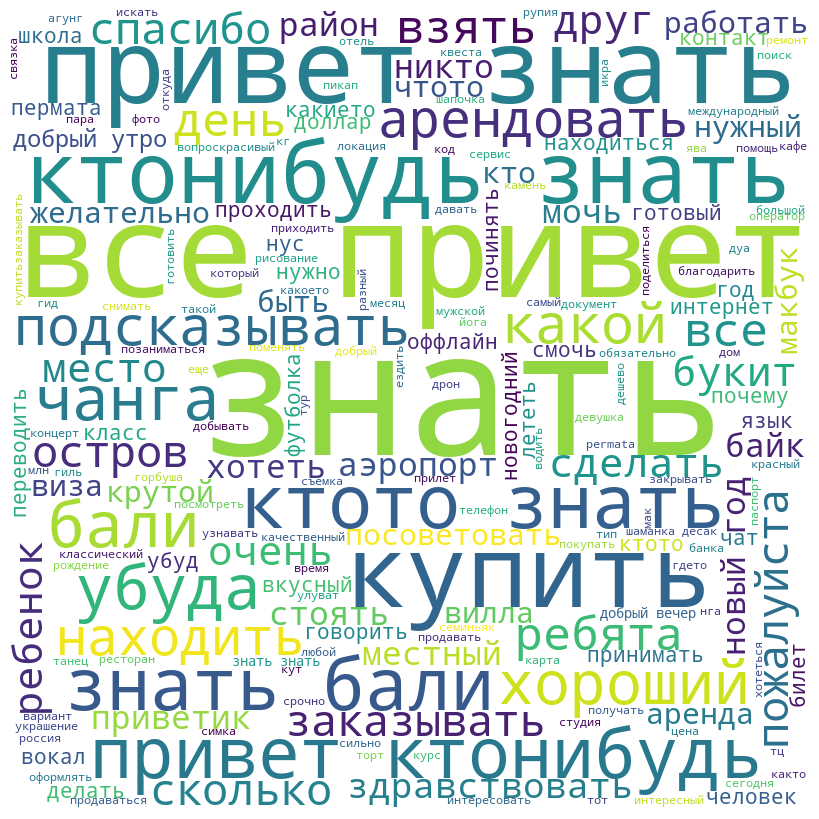

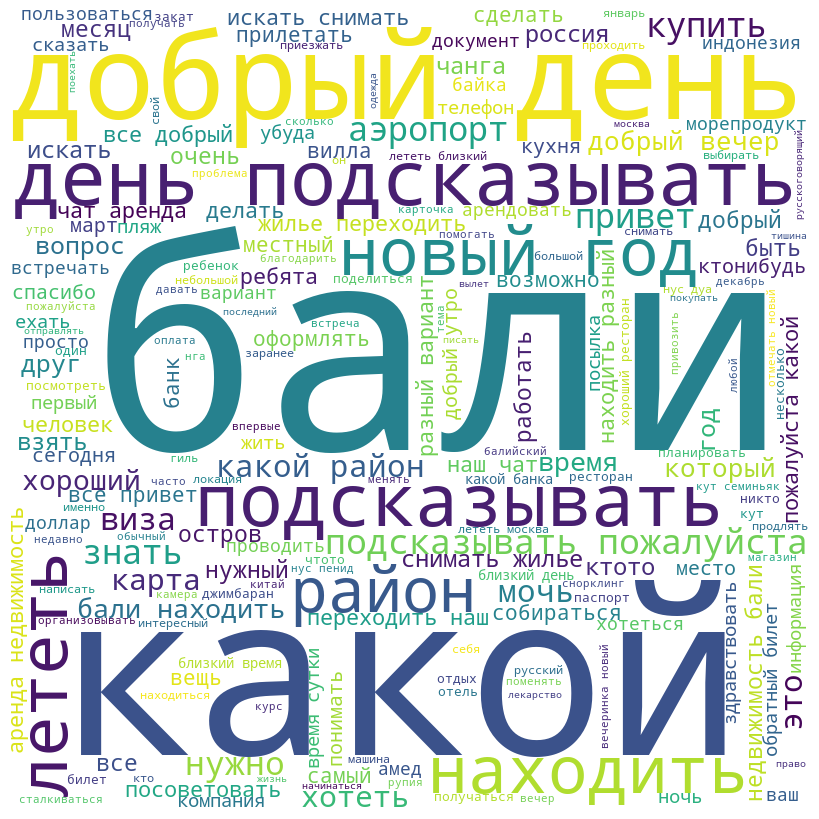

In [276]:
km_wordclouds = generate_wordclouds(df, 'mbk_labels')
show_wordclouds(km_wordclouds)

## AgglomerativeClustering

generating 0 wordcloud.
generating 1 wordcloud.
generating 2 wordcloud.
generating 3 wordcloud.
generating 4 wordcloud.
generating 5 wordcloud.
generating 6 wordcloud.


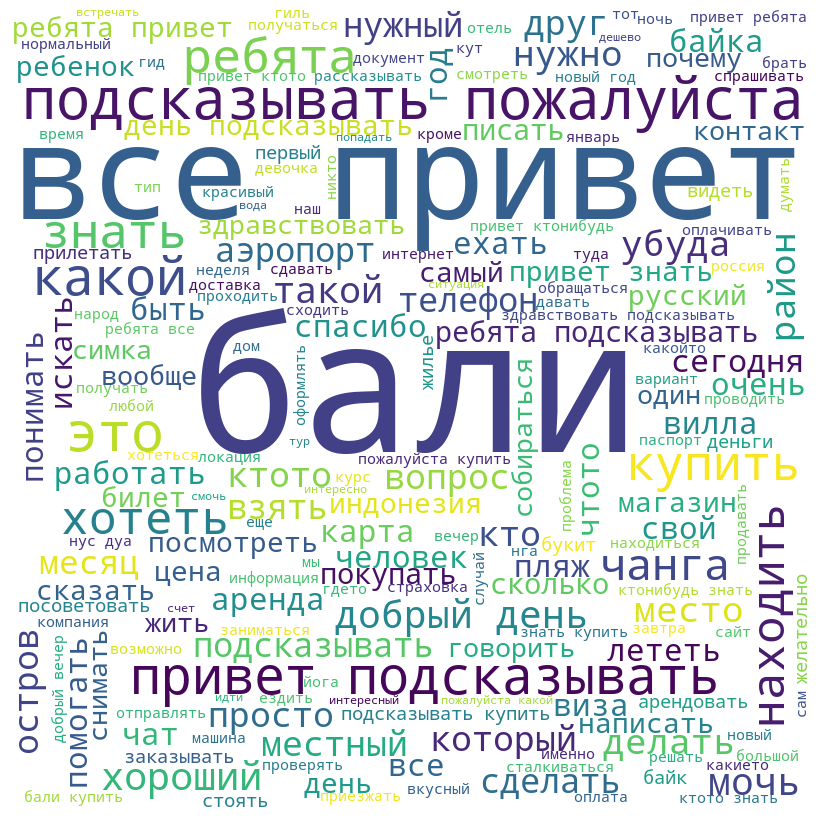

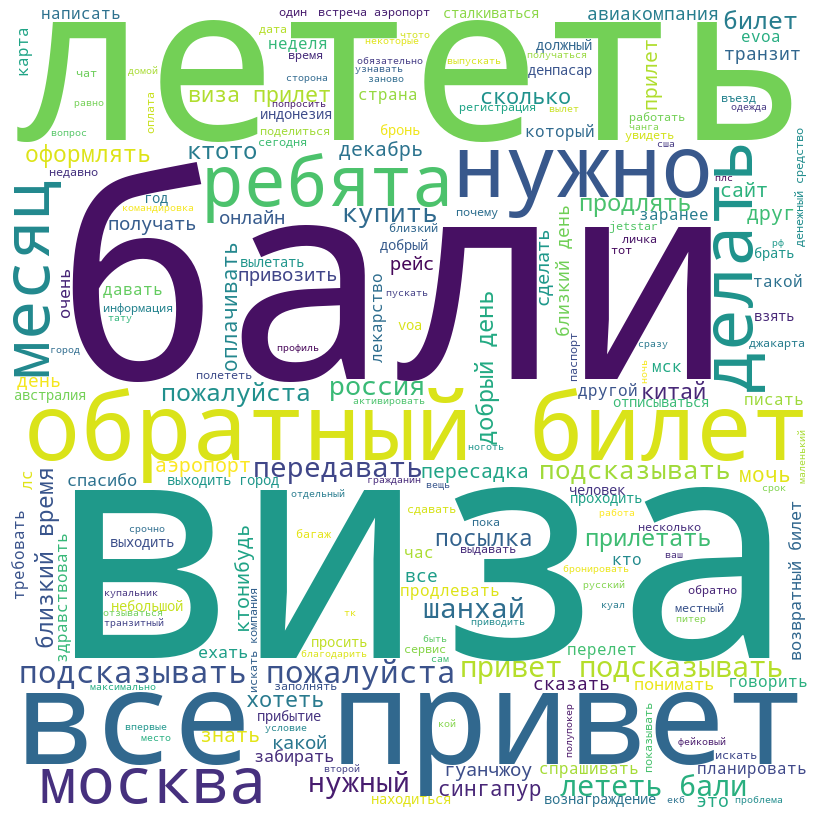

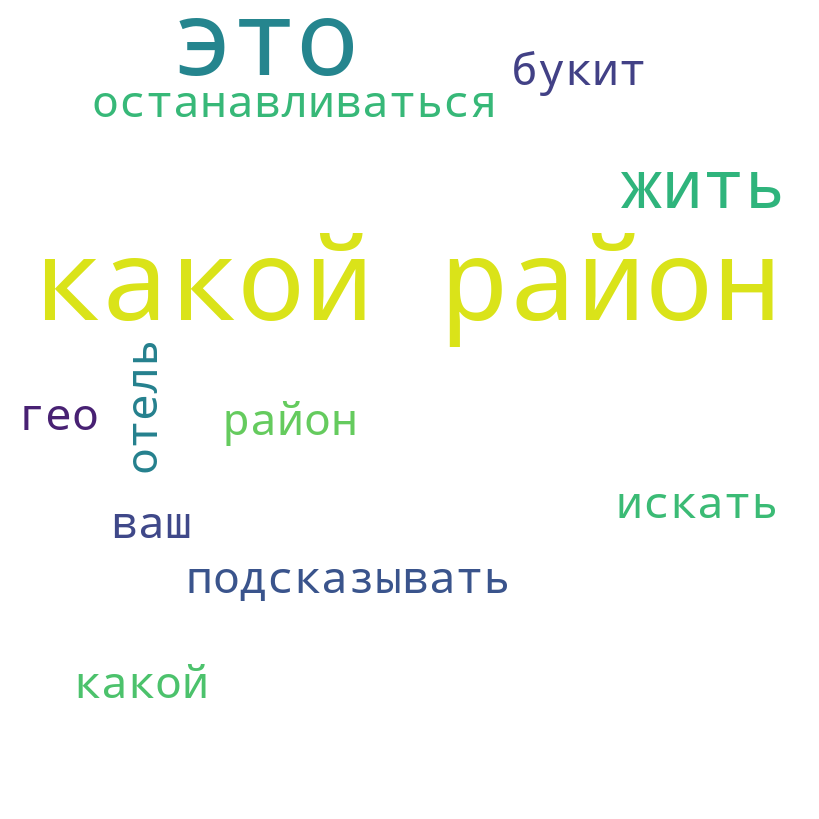

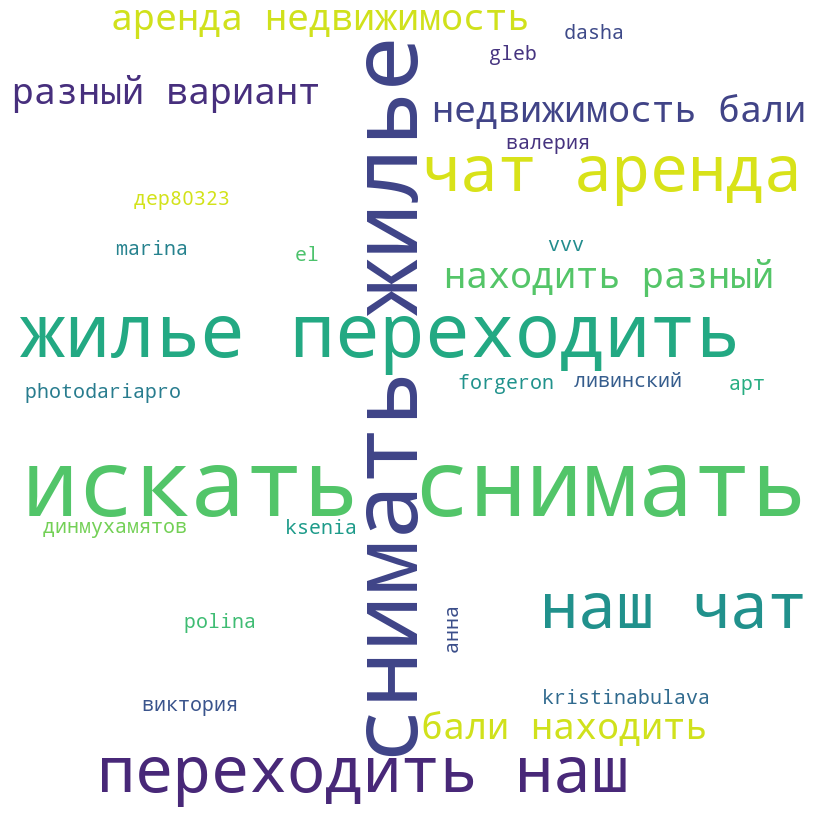

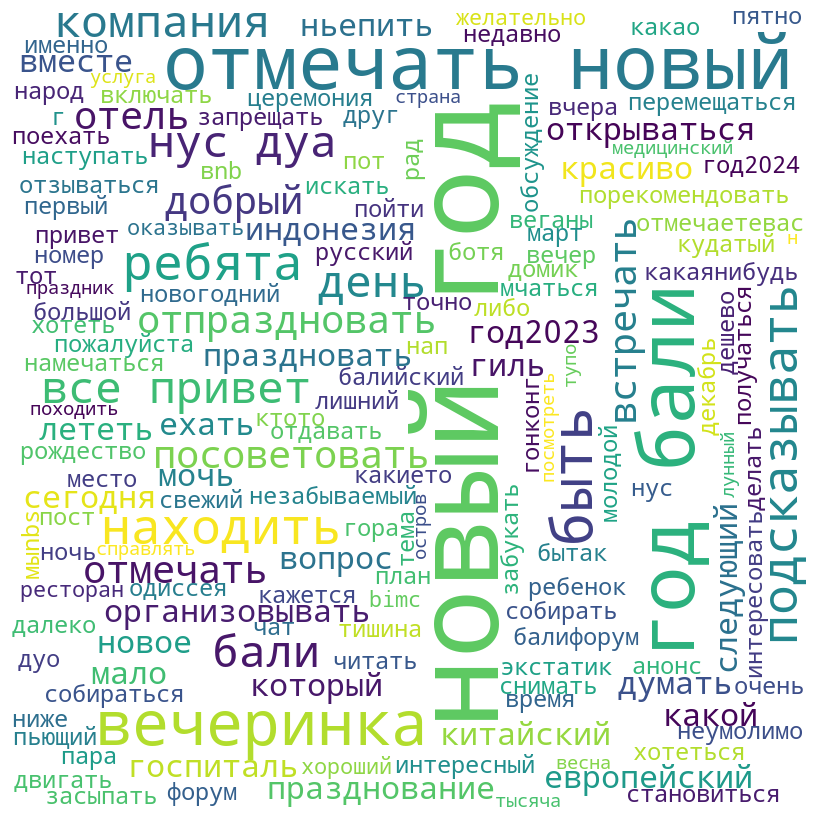

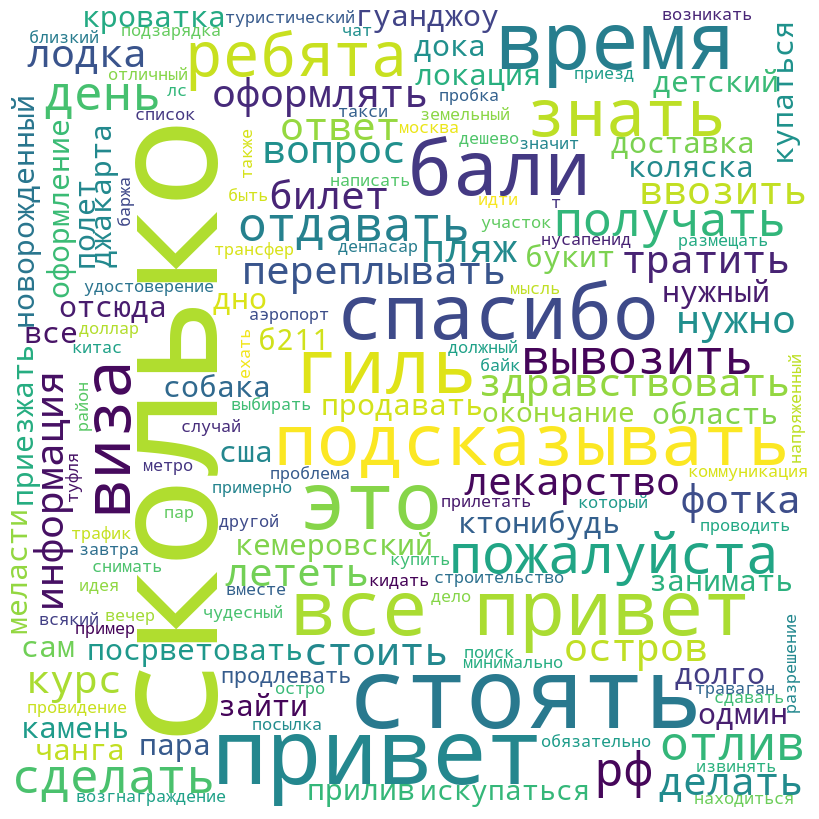

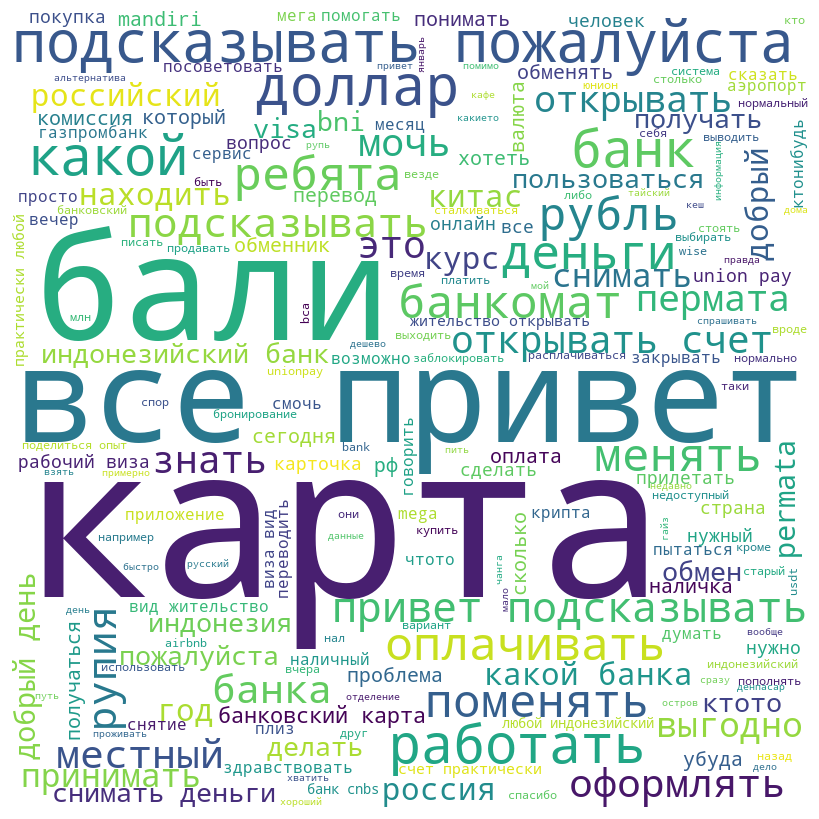

In [278]:
km_wordclouds = generate_wordclouds(df, 'agg_c_labels')
show_wordclouds(km_wordclouds)

# pickles

In [291]:
pickles_dir = './data/pickles'

def picklize(data, name):
    with open(f'{pickles_dir}/{name}.pickle', 'wb') as f:
        pickle.dump(data, f)

def unpicklize(name):
    with open(f'{pickles_dir}/{name}.pickle', 'rb') as f:
        return pickle.load(f)

In [293]:
picklize(df, 'bali_df')

[0, 1, 0, 0, 2, 2]

[{0, 2, 3}]